[WARN] Failed reading summary /Users/Martina.Galletti/Downloads/dati-artis1/aggregated/ALLUSERS_summary_20251024_163111.csv: "None of ['Metric'] are in the columns"
[WARN] Failed reading summary /Users/Martina.Galletti/Downloads/dati-artis1/aggregated/ALLUSERS_summary_20251024_163424.csv: "None of ['Metric'] are in the columns"
[WARN] Failed reading summary /Users/Martina.Galletti/Downloads/dati-artis1/aggregated/ALLUSERS_summary_20251024_163450.csv: "None of ['Metric'] are in the columns"
[WARN] Failed reading summary /Users/Martina.Galletti/Downloads/dati-artis1/correlations/results/temporal_accuracy_summary_20251024_162358.csv: 'DataFrame' object has no attribute 'str'
[WARN] Failed reading summary /Users/Martina.Galletti/Downloads/dati-artis1/pre-post/summary_statistics.csv: "None of ['Metric'] are in the columns"
[WARN] Failed reading temporal /Users/Martina.Galletti/Downloads/dati-artis1/correlations/results/all_users_temporal_accuracy_20251024_162358.csv: Missing column provided

/var/folders/xg/275fmmmx52b3sq21l50dn4yw0000gn/T/ipykernel_66390/1577101810.py:279: UserWarning: Glyph 8600 (\N{SOUTH EAST ARROW}) missing from font(s) Times New Roman.
  plt.tight_layout()
/var/folders/xg/275fmmmx52b3sq21l50dn4yw0000gn/T/ipykernel_66390/1577101810.py:279: UserWarning: Glyph 8599 (\N{NORTH EAST ARROW}) missing from font(s) Times New Roman.
  plt.tight_layout()
/Users/Martina.Galletti/Downloads/dati-artis1/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8600 (\N{SOUTH EAST ARROW}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Martina.Galletti/Downloads/dati-artis1/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8599 (\N{NORTH EAST ARROW}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)


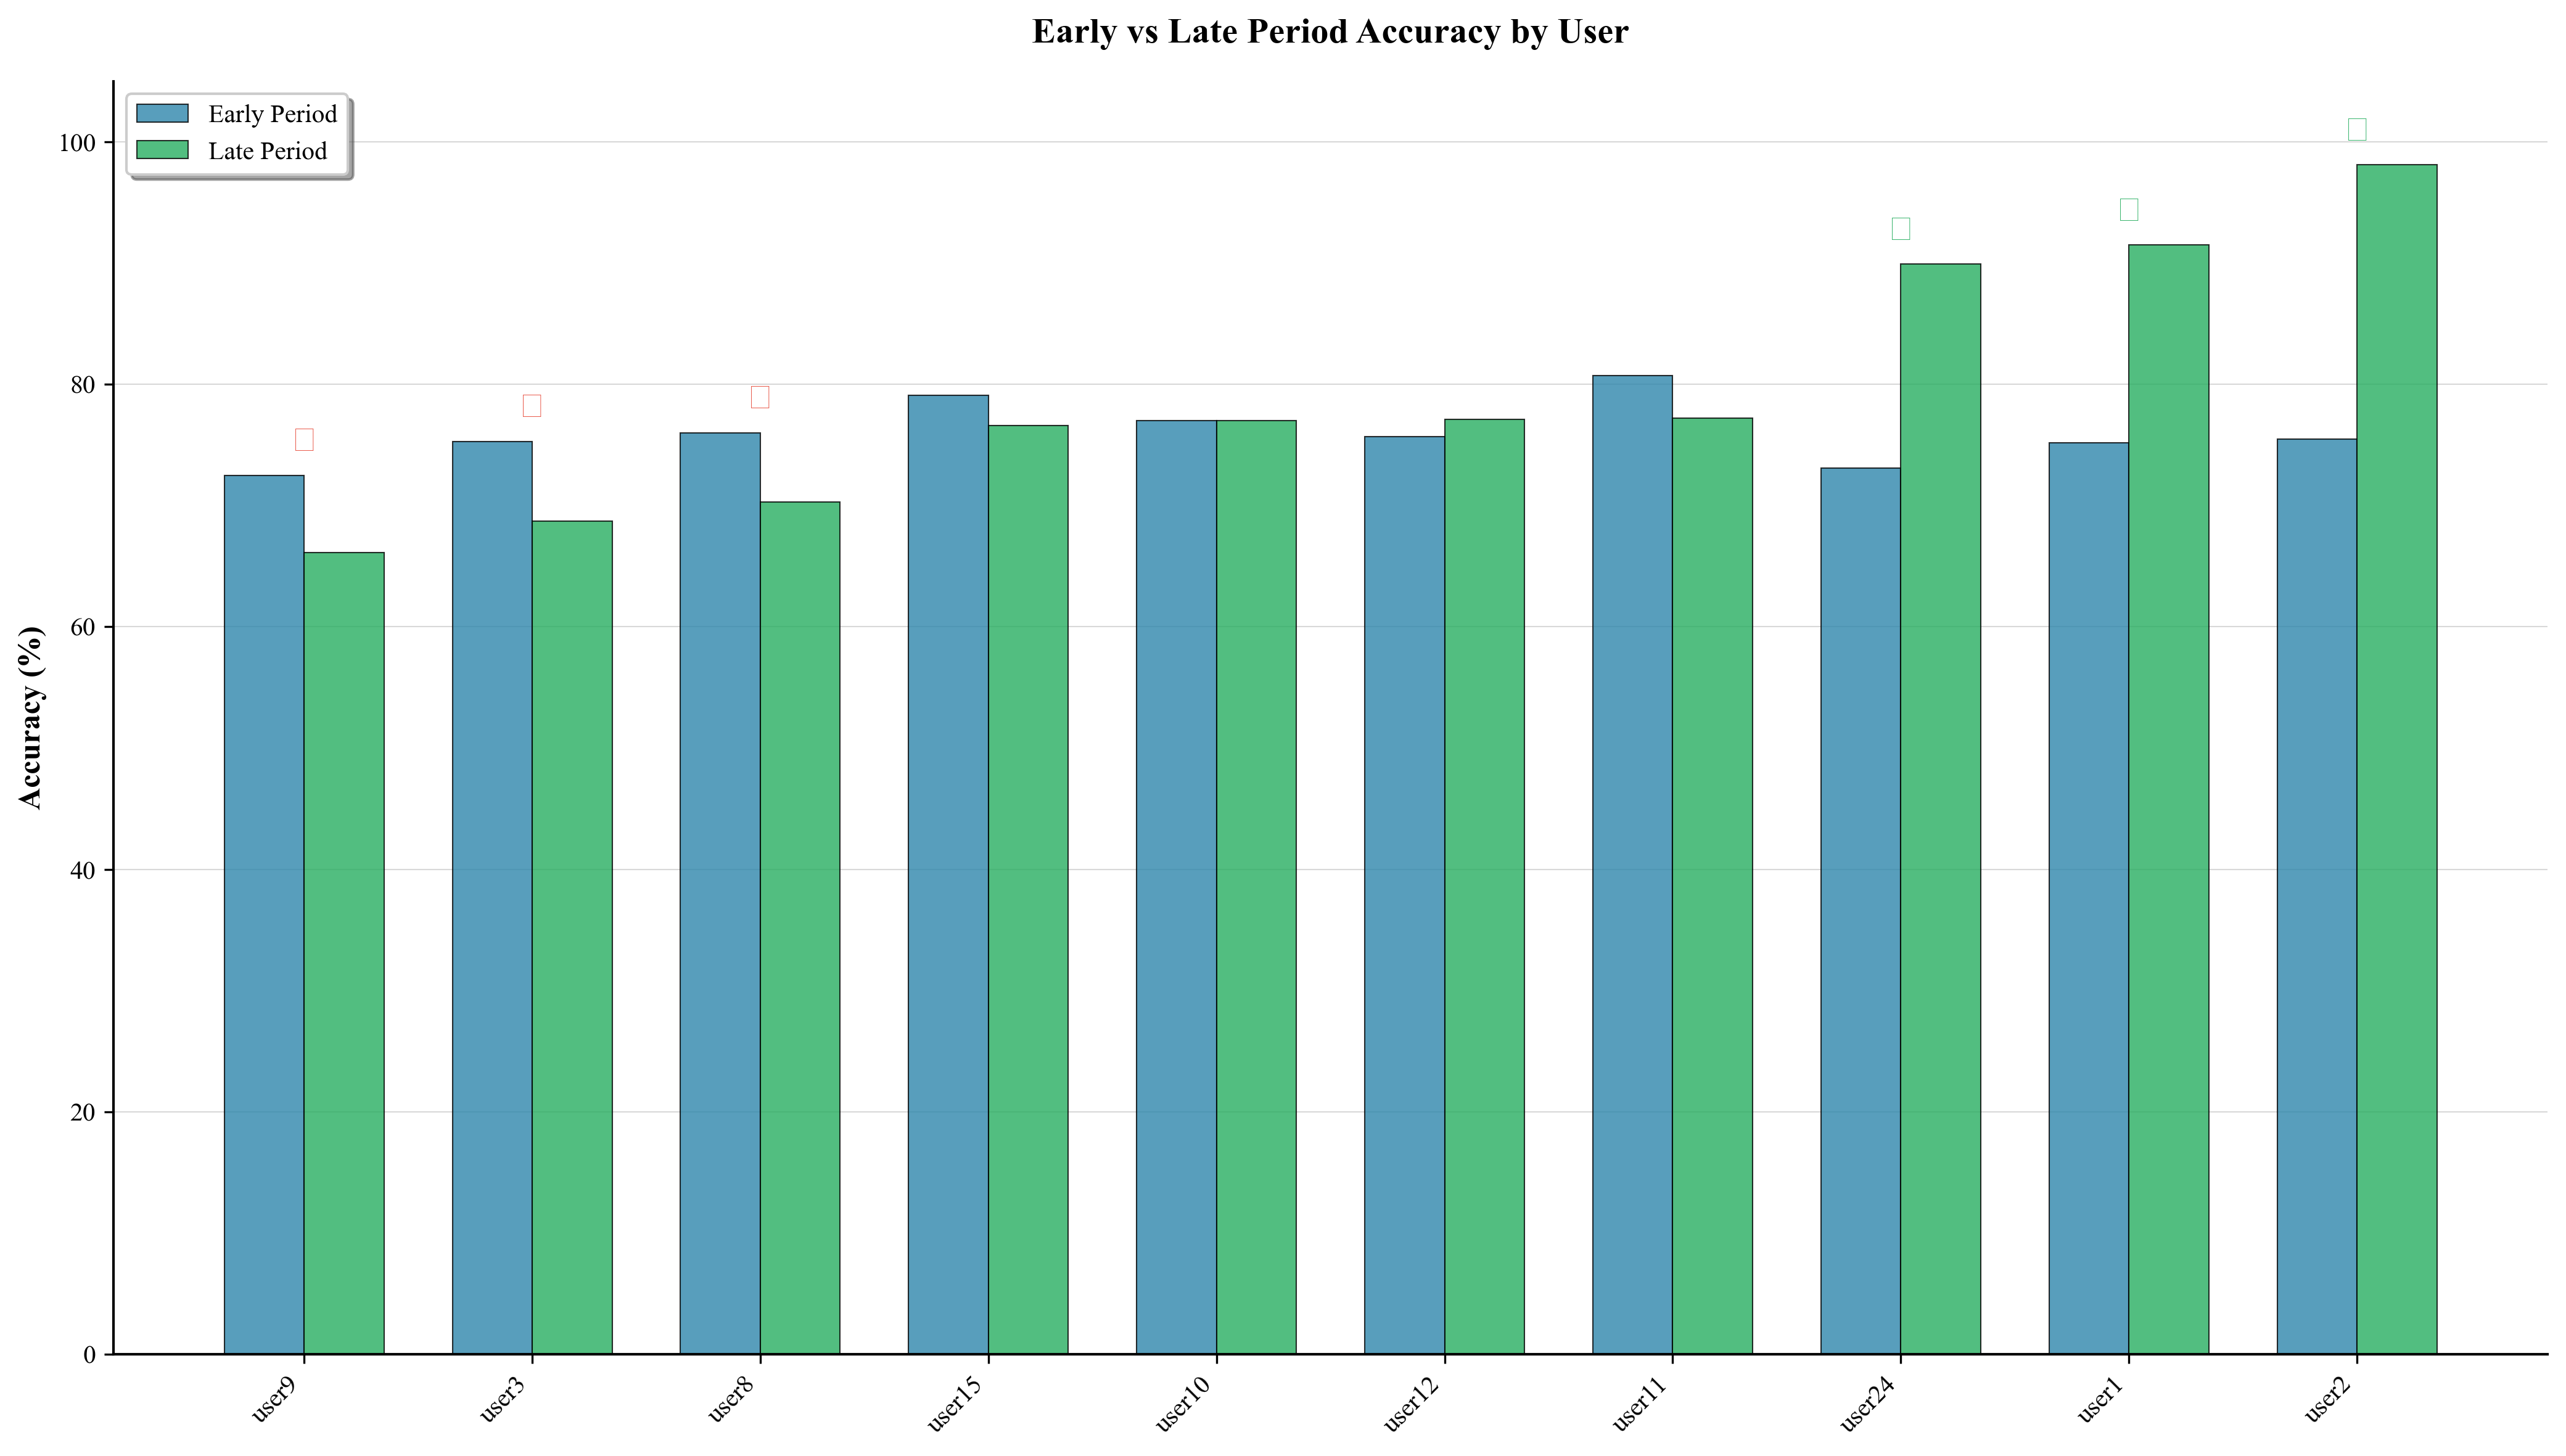

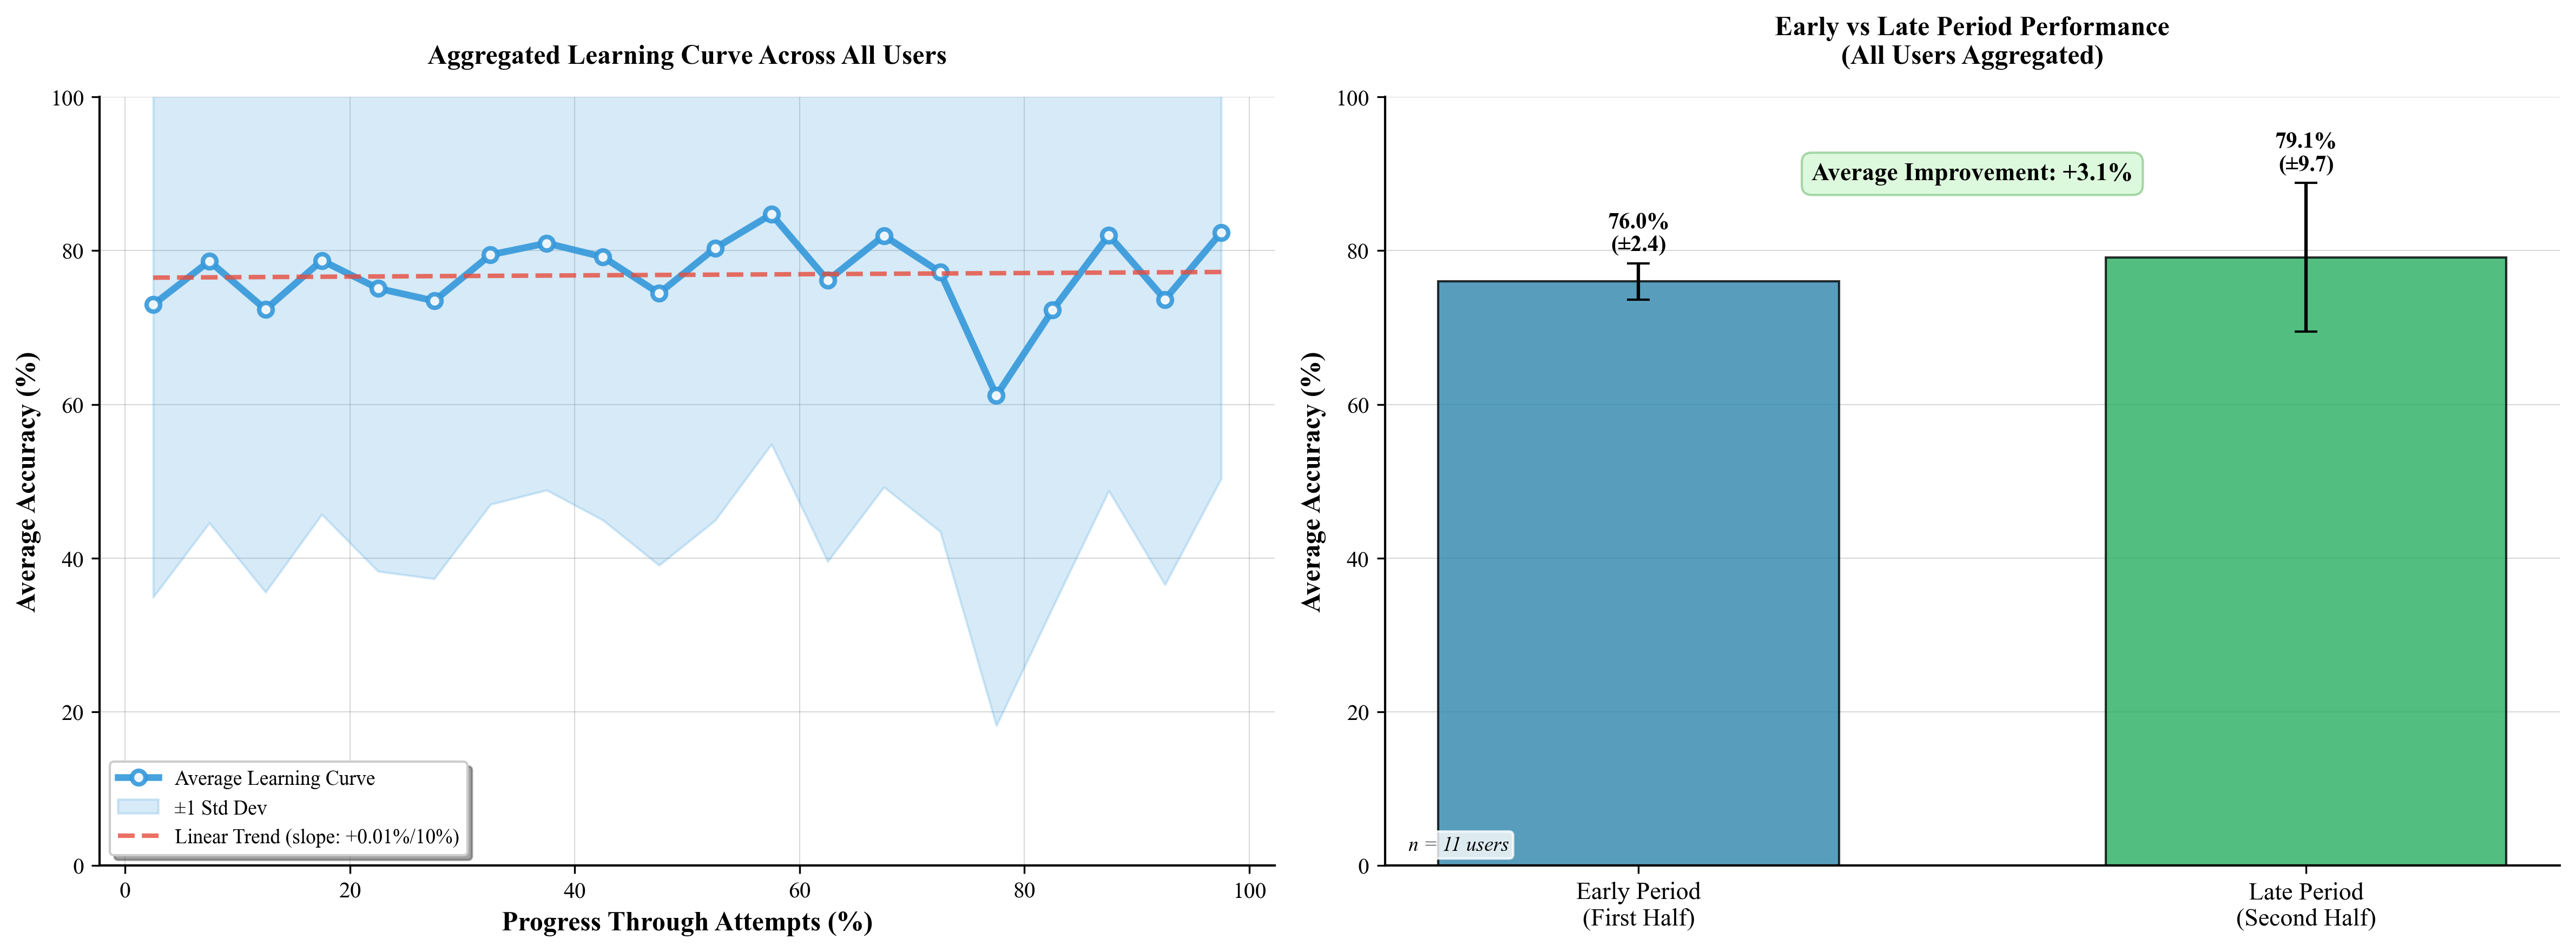

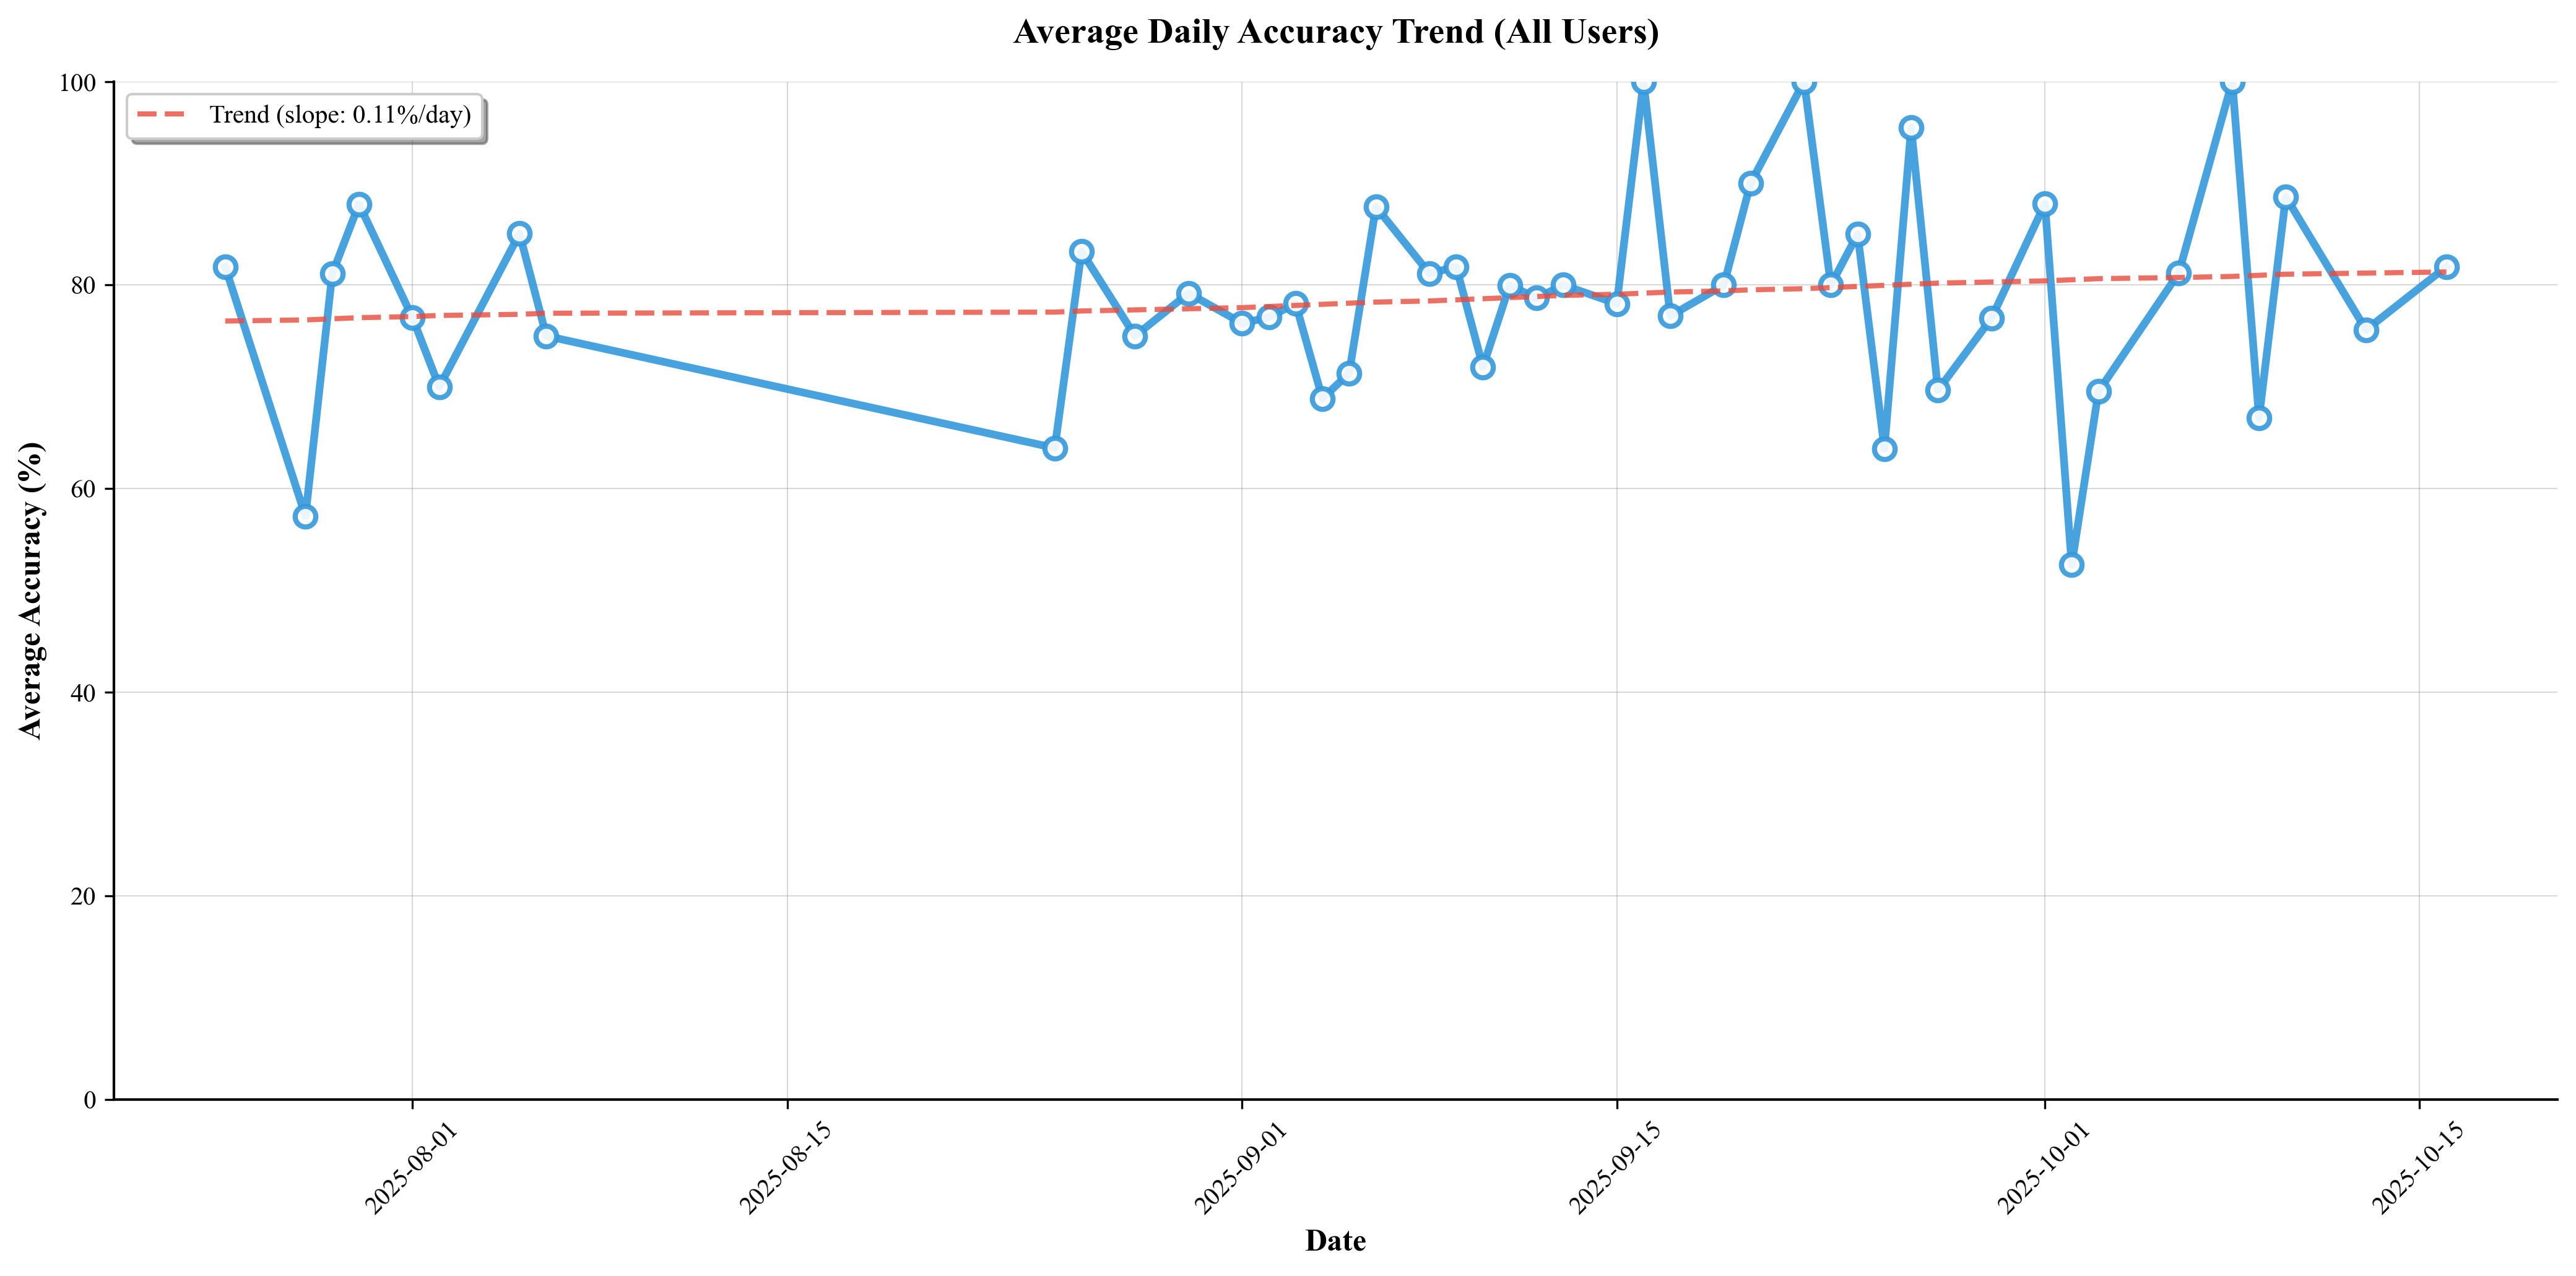

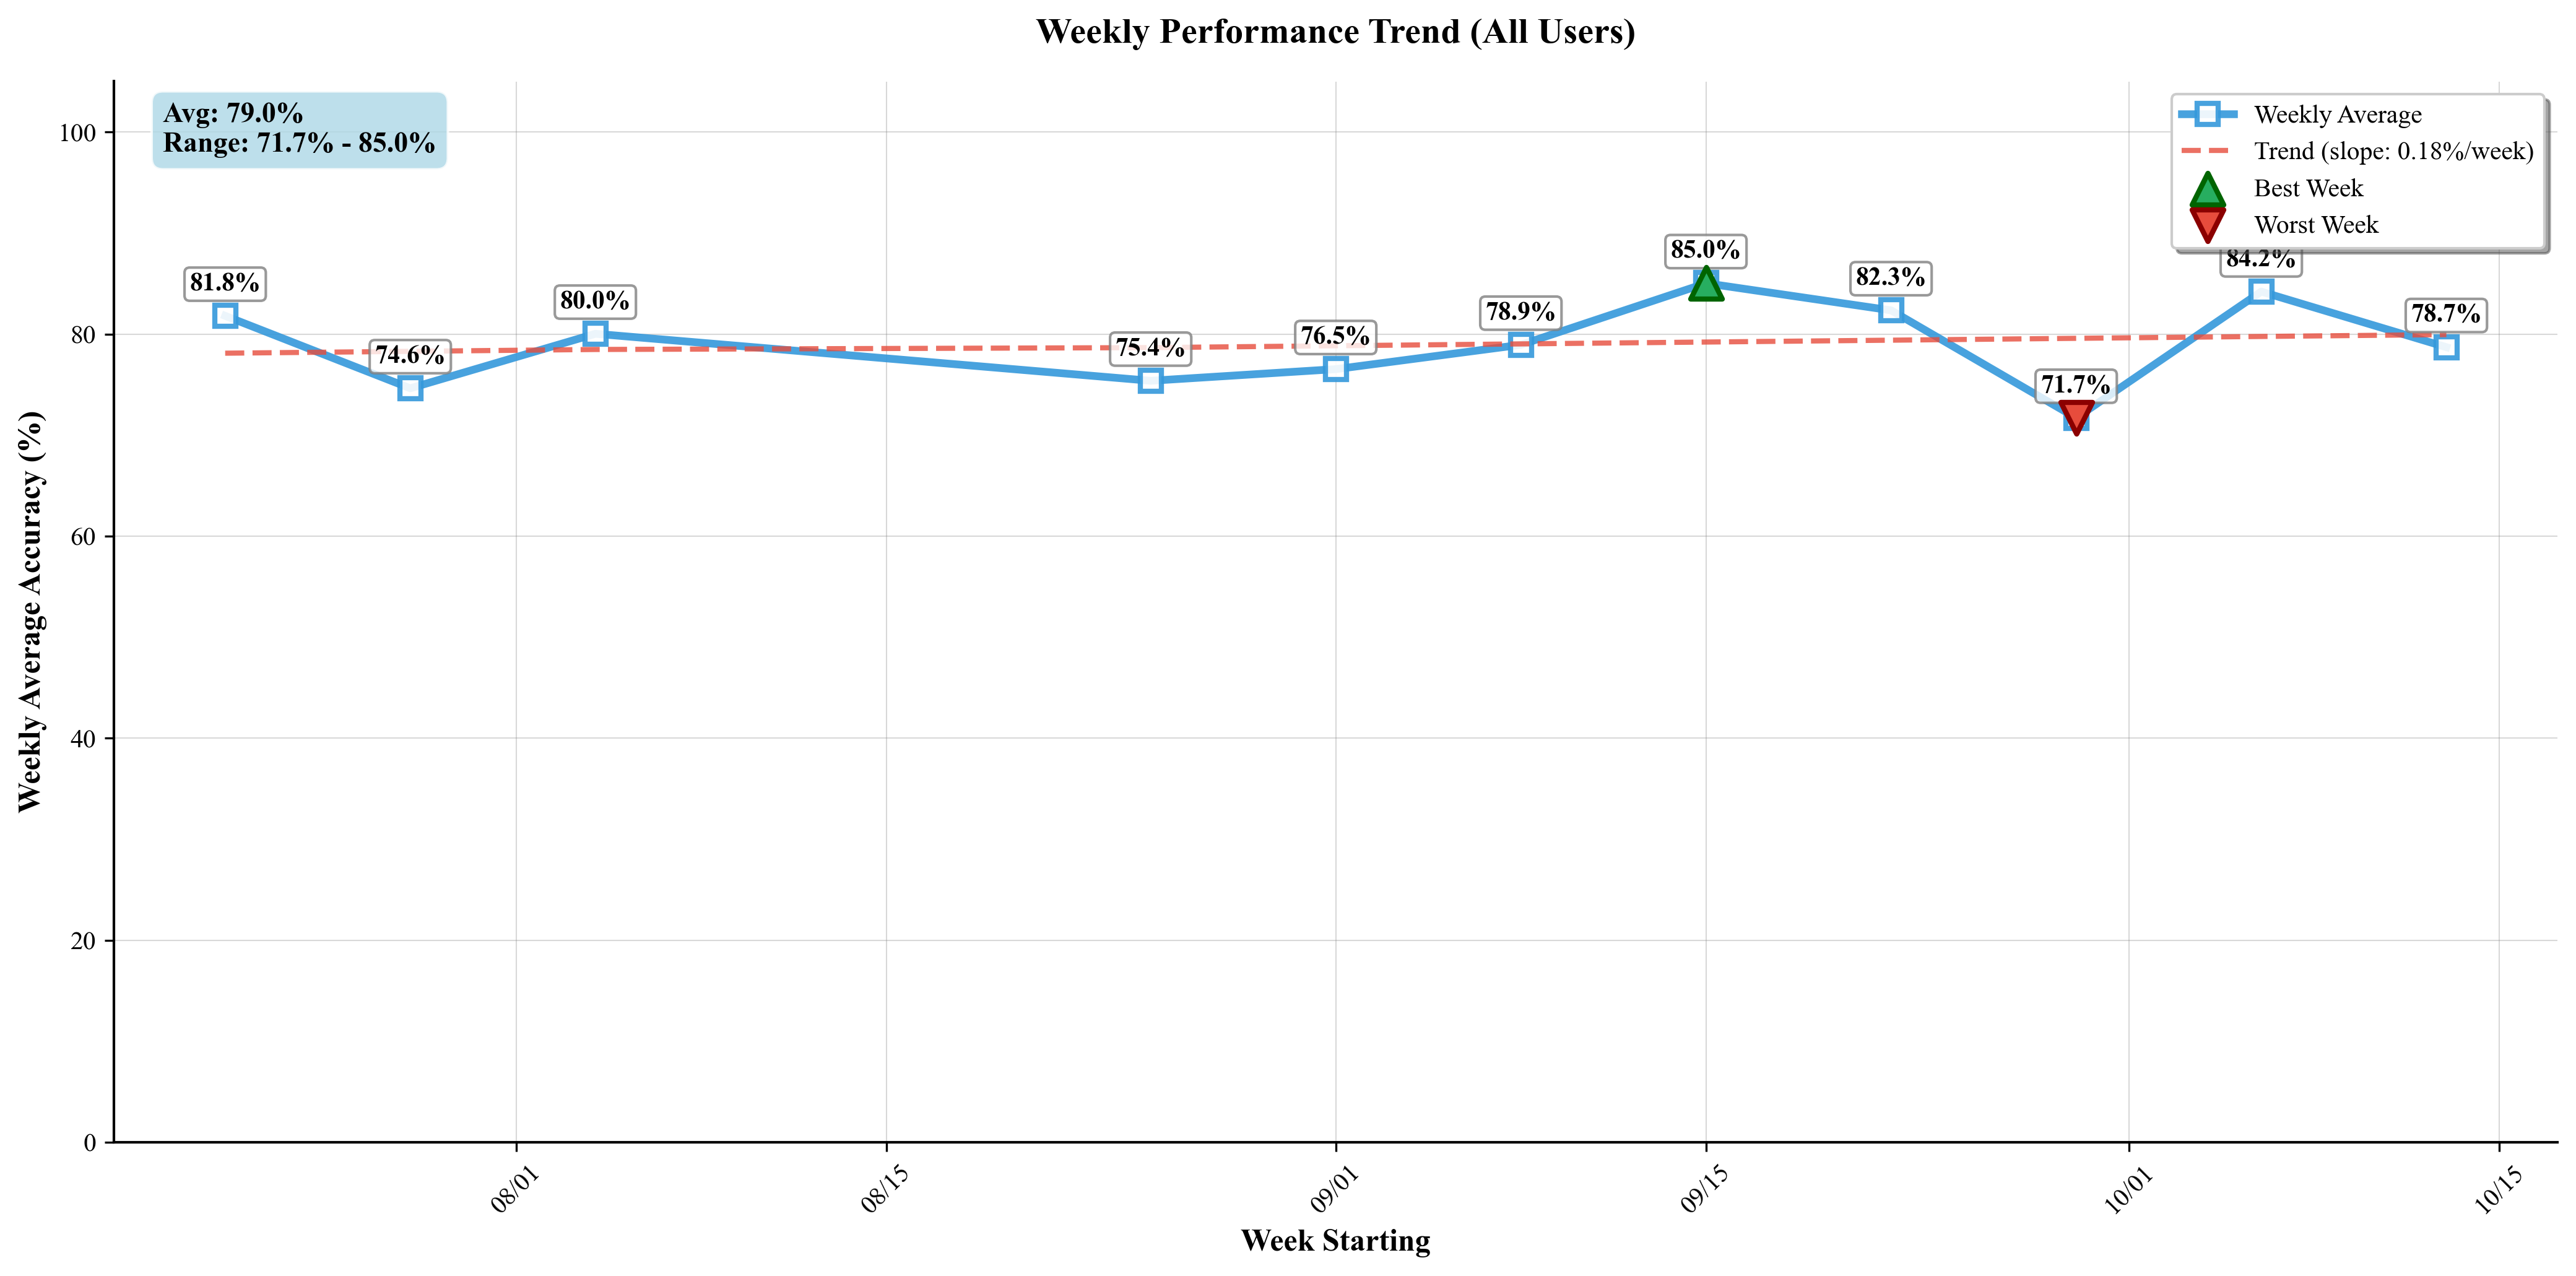

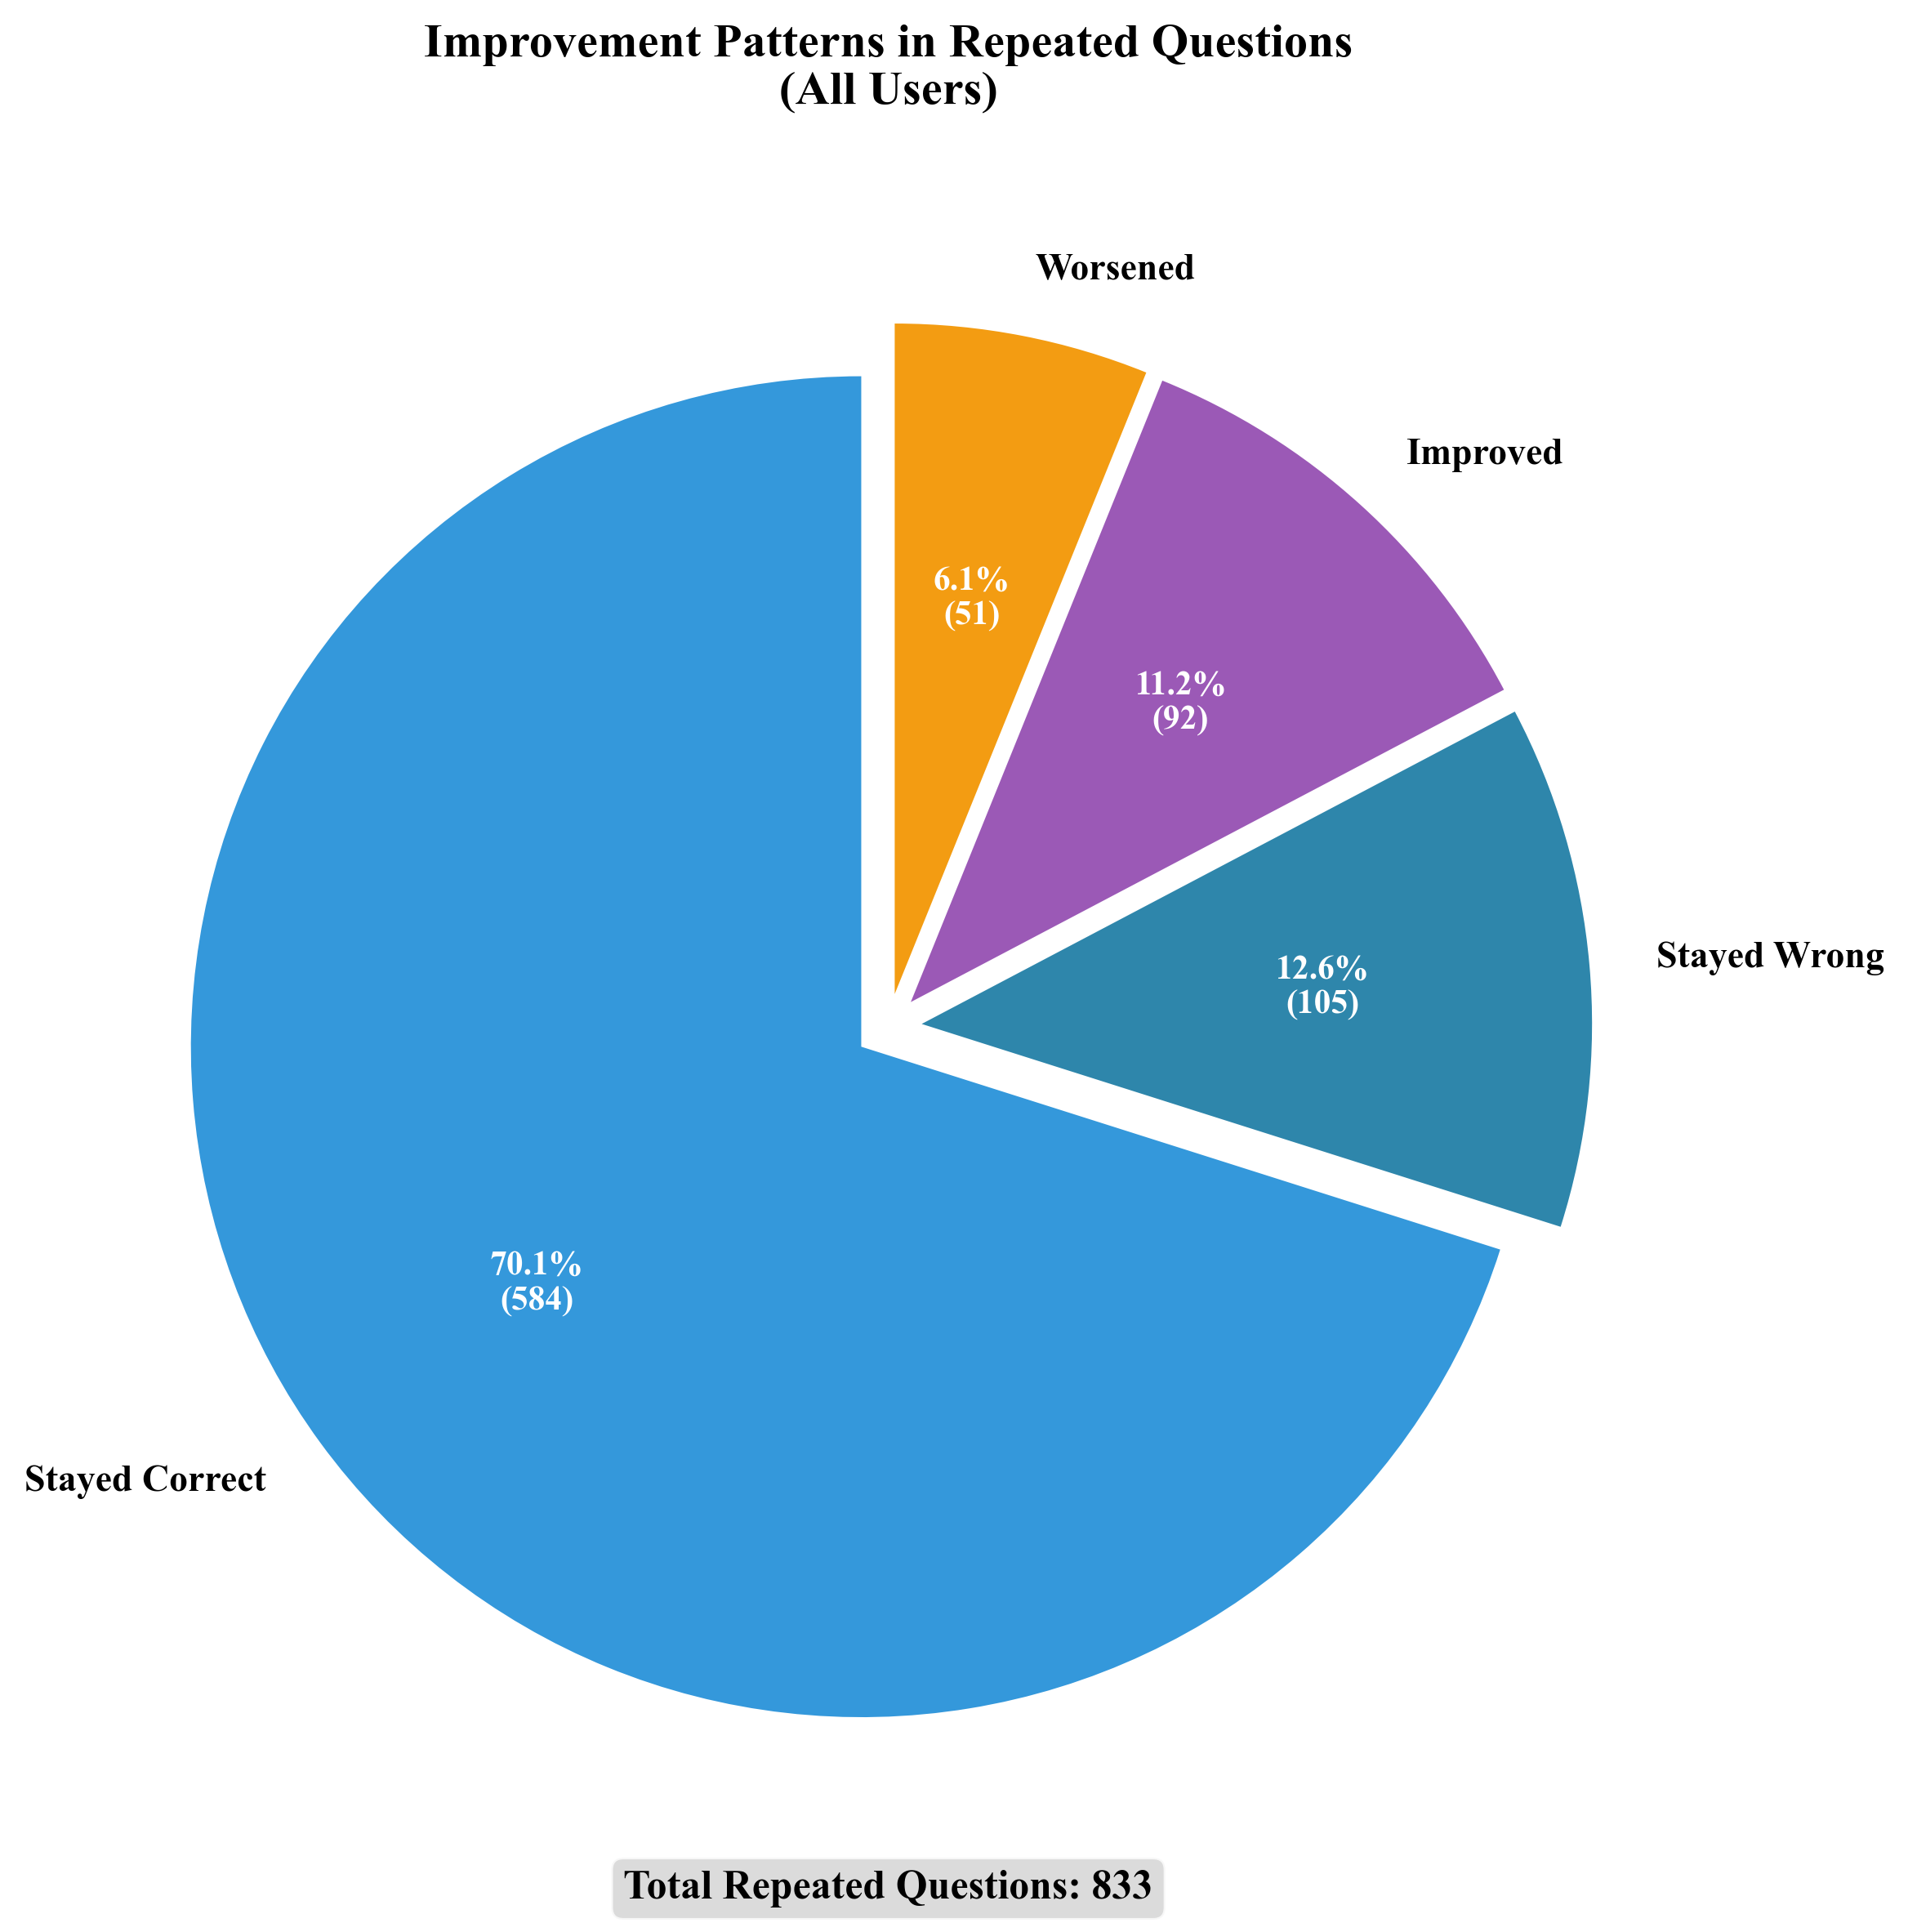

In [9]:
import os, re, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# ------------------------
# Config
# ------------------------
BASE_DIR = "/Users/Martina.Galletti/Downloads/dati-artis1"

# ------------------------
# Helpers
# ------------------------
def infer_user_id(path: str) -> str:
    """
    Infer a user id from file path - updated for your specific structure
    """
    patterns = [
        r"user(\d+)",           # matches user15, user24, etc.
        r"User(\d+)",           # matches User15, User24, etc.  
        r"/(\w+)/[^/]*\.csv$",  # matches directory name before csv
    ]
    
    for pattern in patterns:
        m = re.search(pattern, path, re.IGNORECASE)
        if m:
            if pattern.startswith(r"user"):
                return f"user{m.group(1)}"
            else:
                return m.group(1).lower()
    
    print(f"Warning: Could not extract user_id from path: {path}")
    return "unknown_user"

def read_summary(path):
    df = pd.read_csv(path)
    wide = df.set_index("Metric")["Value"].to_frame().T
    wide = wide.reset_index(drop=True)

    for col in wide.columns:
        s = wide[col].astype(str).str.replace('%', '', regex=False)
        wide[col] = pd.to_numeric(s, errors='coerce')

    wide["user_id"] = infer_user_id(path)
    wide["source_path"] = path
    return wide

def read_generic_with_user(path, parse_dates=None):
    df = pd.read_csv(path, parse_dates=parse_dates or [])
    df["user_id"] = infer_user_id(path)
    df["source_path"] = path
    return df

# ------------------------
# Sweep files
# ------------------------
def sweep_files(base_dir):
    patterns = {
        "summary":         "**/*summary_*.csv",
        "stories":         "**/*stories_*.csv",
        "questions":       "**/*questions_*.csv",
        "temporal":        "**/*temporal_*.csv",
        "daily":           "**/*daily_*.csv",
        "distribution":    "**/*distribution_*.csv",
        "multiple":        "**/*multiple_attempts_*.csv",
    }
    found = {k: sorted(glob.glob(os.path.join(base_dir, pat), recursive=True)) for k, pat in patterns.items()}
    return found

# ------------------------
# Load all users' CSVs
# ------------------------
def load_all(base_dir):
    files = sweep_files(base_dir)

    # 1) summaries -> one row per user
    summaries = []
    for p in files["summary"]:
        try:
            summaries.append(read_summary(p))
        except Exception as e:
            print(f"[WARN] Failed reading summary {p}: {e}")
    df_summary = pd.concat(summaries, ignore_index=True) if summaries else pd.DataFrame()

    # 2) stories
    stories = []
    for p in files["stories"]:
        try:
            stories.append(read_generic_with_user(p))
        except Exception as e:
            print(f"[WARN] Failed reading stories {p}: {e}")
    df_stories = pd.concat(stories, ignore_index=True) if stories else pd.DataFrame()

    # 3) questions
    questions = []
    for p in files["questions"]:
        try:
            questions.append(read_generic_with_user(p))
        except Exception as e:
            print(f"[WARN] Failed reading questions {p}: {e}")
    df_questions = pd.concat(questions, ignore_index=True) if questions else pd.DataFrame()

    # 4) temporal (parse Date)
    temporals = []
    for p in files["temporal"]:
        try:
            temporals.append(read_generic_with_user(p, parse_dates=["Date"]))
        except Exception as e:
            print(f"[WARN] Failed reading temporal {p}: {e}")
    df_temporal = pd.concat(temporals, ignore_index=True) if temporals else pd.DataFrame()

    # 5) daily (parse Date)
    dailies = []
    for p in files["daily"]:
        try:
            dailies.append(read_generic_with_user(p, parse_dates=["Date"]))
        except Exception as e:
            print(f"[WARN] Failed reading daily {p}: {e}")
    df_daily = pd.concat(dailies, ignore_index=True) if dailies else pd.DataFrame()

    # 6) distribution
    dists = []
    for p in files["distribution"]:
        try:
            dists.append(read_generic_with_user(p))
        except Exception as e:
            print(f"[WARN] Failed reading distribution {p}: {e}")
    df_distribution = pd.concat(dists, ignore_index=True) if dists else pd.DataFrame()

    # 7) multiple attempts
    multiples = []
    for p in files["multiple"]:
        try:
            multiples.append(read_generic_with_user(p))
        except Exception as e:
            print(f"[WARN] Failed reading multiple {p}: {e}")
    df_multiple = pd.concat(multiples, ignore_index=True) if multiples else pd.DataFrame()

    return {
        "summary": df_summary,
        "stories": df_stories,
        "questions": df_questions,
        "temporal": df_temporal,
        "daily": df_daily,
        "distribution": df_distribution,
        "multiple": df_multiple,
    }

# ------------------------
# Aggregations
# ------------------------
def aggregate_metrics(dfs):
    out = {}

    # Overall accuracy per user (from summary)
    df_sum = dfs["summary"].copy()
    if not df_sum.empty:
        def tonum(s):
            if pd.isna(s): return np.nan
            s = str(s).replace('%','')
            try: return float(s)
            except: return np.nan

        for col in df_sum.columns:
            if col not in ("user_id", "source_path"):
                df_sum[col] = df_sum[col].apply(tonum)

        keep_cols = ["user_id"]
        for c in ["Overall Accuracy (%)", "Early Period Accuracy (%)", "Late Period Accuracy (%)", "Temporal Improvement (%)"]:
            if c in df_sum.columns: keep_cols.append(c)
        out["per_user_summary"] = df_sum[keep_cols].drop_duplicates("user_id")

    # Daily accuracy merged across all users
    df_dy = dfs["daily"].copy()
    if not df_dy.empty:
        df_dy["Daily_Accuracy_Percent"] = pd.to_numeric(df_dy["Daily_Accuracy_Percent"], errors="coerce")
        out["daily_all_users"] = (
            df_dy.groupby("Date", as_index=False)["Daily_Accuracy_Percent"].mean()
                 .rename(columns={"Daily_Accuracy_Percent":"Avg_Daily_Accuracy"})
                 .sort_values("Date")
        )

    # Temporal data for learning curves
    df_temporal = dfs["temporal"].copy()
    if not df_temporal.empty:
        if "Is_Correct" in df_temporal.columns:
            df_temporal["is_correct"] = df_temporal["Is_Correct"]
        elif "Correct" in df_temporal.columns:
            df_temporal["is_correct"] = df_temporal["Correct"]
        
        out["temporal"] = df_temporal

    # Multiple attempts pattern distribution across users
    df_mp = dfs["multiple"].copy()
    if not df_mp.empty and "Improvement_Pattern" in df_mp.columns:
        out["multiple_patterns"] = (
            df_mp.groupby("Improvement_Pattern", as_index=False).size()
                 .rename(columns={"size":"Count"})
                 .sort_values("Count", ascending=False)
        )

    return out

# ------------------------
# Plots with consistent styling
# ------------------------
def plot_group_results(agg):
    # Configure matplotlib for professional output with white background
    plt.rcParams.update({
        'font.size': 11,
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'savefig.facecolor': 'white',
        'text.color': 'black',
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
        'axes.linewidth': 1.0,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.edgecolor': 'black',
        'axes.axisbelow': True,
        'xtick.bottom': True,
        'ytick.left': True,
        'grid.alpha': 0.3,
        'grid.color': 'gray'
    })

    # Professional color palette
    colors_main = ['#3498DB', '#2E86AB', '#9B59B6', '#F39C12', '#E67E22', '#16A085']
    colors_comparison = ['#2E86AB', '#27AE60']

    # 1) Early vs Late accuracy per user (enhanced bar chart)
    if "per_user_summary" in agg and not agg["per_user_summary"].empty:
        dfu = agg["per_user_summary"].copy()
        if {"Early Period Accuracy (%)","Late Period Accuracy (%)"}.issubset(dfu.columns):
            dfu = dfu.dropna(subset=["Early Period Accuracy (%)","Late Period Accuracy (%)"])
            dfu = dfu.sort_values("Late Period Accuracy (%)", ascending=True)
            
            x = np.arange(len(dfu))
            width = 0.35
            
            fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')
            ax.set_facecolor('white')
            
            bars1 = ax.bar(x - width/2, dfu["Early Period Accuracy (%)"], width, 
                          label="Early Period", color=colors_comparison[0], alpha=0.8,
                          edgecolor='black', linewidth=0.5)
            bars2 = ax.bar(x + width/2, dfu["Late Period Accuracy (%)"], width, 
                          label="Late Period", color=colors_comparison[1], alpha=0.8,
                          edgecolor='black', linewidth=0.5)
            
            ax.set_xticks(x)
            ax.set_xticklabels(dfu["user_id"], rotation=45, ha='right', fontsize=10)
            ax.set_ylabel("Accuracy (%)", fontsize=12, fontweight='bold')
            ax.set_title("Early vs Late Period Accuracy by User", fontsize=14, fontweight='bold', pad=15)
            ax.set_ylim(0, 105)
            ax.legend(fontsize=10, loc='upper left', frameon=True, fancybox=True, shadow=True)
            ax.grid(True, alpha=0.3, axis='y', linestyle='-', linewidth=0.5)
            
            # Add improvement indicators
            for i, (early, late) in enumerate(zip(dfu["Early Period Accuracy (%)"], dfu["Late Period Accuracy (%)"])):
                improvement = late - early
                if improvement > 5:
                    ax.annotate('↗', xy=(i, max(early, late) + 2), ha='center', 
                               fontsize=14, color='#27AE60', fontweight='bold')
                elif improvement < -5:
                    ax.annotate('↘', xy=(i, max(early, late) + 2), ha='center', 
                               fontsize=14, color='#E74C3C', fontweight='bold')
            
            ax.tick_params(axis='both', labelsize=10)
            plt.tight_layout()
            plt.show()

    # 2) Learning Curve Analysis
    if "temporal" in agg and not agg["temporal"].empty:
        df_temporal = agg["temporal"].copy()
        
        # Check if we have correctness data
        if 'is_correct' in df_temporal.columns and 'Date' in df_temporal.columns:
            # Sort by date and create attempt sequence
            df_temporal = df_temporal.sort_values('Date')
            
            # Create the learning curve plots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), facecolor='white')
            ax1.set_facecolor('white')
            ax2.set_facecolor('white')
            
            # Plot 1: Aggregated Learning Curve
            all_attempts = []
            all_correctness = []
            
            for user_id in df_temporal['user_id'].unique():
                user_data = df_temporal[df_temporal['user_id'] == user_id].sort_values('Date')
                if len(user_data) > 10:  # Only include users with sufficient data
                    attempt_numbers = np.arange(1, len(user_data) + 1)
                    rw = max(1, min(10, len(user_data)//4))
                    rolling_acc = user_data['is_correct'].rolling(window=rw, min_periods=1).mean()*100
                    
                    # Normalize attempt numbers to percentage of completion
                    normalized_attempts = attempt_numbers / len(user_data) * 100
                    
                    # Store for aggregation
                    all_attempts.extend(normalized_attempts)
                    all_correctness.extend(rolling_acc)
            
            if len(all_attempts) > 0:
                # Create bins for aggregation
                attempt_bins = np.linspace(0, 100, 21)  # 20 bins
                bin_centers = (attempt_bins[:-1] + attempt_bins[1:]) / 2
                
                # Calculate mean accuracy for each bin
                binned_accuracy = []
                binned_std = []
                
                for i in range(len(attempt_bins) - 1):
                    mask = (np.array(all_attempts) >= attempt_bins[i]) & (np.array(all_attempts) < attempt_bins[i+1])
                    if mask.sum() > 0:
                        bin_acc = np.array(all_correctness)[mask]
                        binned_accuracy.append(np.mean(bin_acc))
                        binned_std.append(np.std(bin_acc))
                    else:
                        binned_accuracy.append(np.nan)
                        binned_std.append(np.nan)
                
                # Remove NaN values
                valid_mask = ~np.isnan(binned_accuracy)
                valid_centers = bin_centers[valid_mask]
                valid_accuracy = np.array(binned_accuracy)[valid_mask]
                valid_std = np.array(binned_std)[valid_mask]
                
                # Plot aggregated learning curve
                ax1.plot(valid_centers, valid_accuracy, color='#3498DB', linewidth=3, alpha=0.9,
                        label='Average Learning Curve', marker='o', markersize=6,
                        markerfacecolor='white', markeredgewidth=2)
                
                # Add confidence band
                ax1.fill_between(valid_centers, 
                               valid_accuracy - valid_std, 
                               valid_accuracy + valid_std,
                               alpha=0.2, color='#3498DB', label='±1 Std Dev')
                
                # Add trend line
                if len(valid_centers) > 3:
                    z = np.polyfit(valid_centers, valid_accuracy, 1)
                    p = np.poly1d(z)
                    trend_line = p(valid_centers)
                    ax1.plot(valid_centers, trend_line, "--", color='#E74C3C', alpha=0.8, 
                            linewidth=2, label=f'Linear Trend (slope: {z[0]:+.2f}%/10%)')
                
                ax1.set_xlabel('Progress Through Attempts (%)', fontweight='bold', fontsize=12)
                ax1.set_ylabel('Average Accuracy (%)', fontweight='bold', fontsize=12)
                ax1.set_title('Aggregated Learning Curve Across All Users', fontsize=12, fontweight='bold', pad=15)
                ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
                ax1.set_ylim(0, 100)
                ax1.legend(fontsize=9, frameon=True, fancybox=True, shadow=True)
                ax1.tick_params(axis='both', labelsize=10)
            
            # Plot 2: Early vs Late Period Comparison (Aggregated)
            early_accuracies = []
            late_accuracies = []
            
            for user_id in df_temporal['user_id'].unique():
                user_data = df_temporal[df_temporal['user_id'] == user_id]
                if len(user_data) > 5:  # Minimum attempts for meaningful split
                    total_attempts = len(user_data)
                    early_attempts = user_data.iloc[:total_attempts//2]
                    late_attempts = user_data.iloc[total_attempts//2:]
                    
                    early_acc = early_attempts['is_correct'].mean() * 100
                    late_acc = late_attempts['is_correct'].mean() * 100
                    
                    early_accuracies.append(early_acc)
                    late_accuracies.append(late_acc)
            
            if len(early_accuracies) > 0:
                # Calculate aggregate statistics
                mean_early = np.mean(early_accuracies)
                mean_late = np.mean(late_accuracies)
                std_early = np.std(early_accuracies)
                std_late = np.std(late_accuracies)
                
                periods = ['Early Period\n(First Half)', 'Late Period\n(Second Half)']
                means = [mean_early, mean_late]
                stds = [np.nan_to_num(std_early), np.nan_to_num(std_late)]
                
                bars = ax2.bar(periods, means, yerr=stds, capsize=5, 
                              color=colors_comparison, alpha=0.8, width=0.6, 
                              edgecolor='black', linewidth=1)
                
                ax2.set_ylabel('Average Accuracy (%)', fontweight='bold', fontsize=12)
                ax2.set_title('Early vs Late Period Performance\n(All Users Aggregated)', 
                             fontsize=12, fontweight='bold', pad=15)
                ax2.set_ylim(0, 100)
                ax2.grid(True, alpha=0.3, axis='y', linestyle='-', linewidth=0.5)
                ax2.tick_params(axis='x', labelsize=11)
                ax2.tick_params(axis='y', labelsize=10)
                
                # Add value labels
                for i, (bar, mean_val, std_val) in enumerate(zip(bars, means, stds)):
                    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + std_val + 1,
                            f'{mean_val:.1f}%\n(±{std_val:.1f})', ha='center', va='bottom', 
                            fontweight='bold', fontsize=10)
                
                # Add improvement indicator
                improvement = mean_late - mean_early
                if improvement > 0:
                    ax2.text(0.50, 0.90, f'Average Improvement: +{improvement:.1f}%', 
                            transform=ax2.transAxes, ha='center', va='center', 
                            fontweight='bold', fontsize=11,
                            bbox=dict(boxstyle="round,pad=0.4", facecolor='lightgreen', 
                                     alpha=0.3, edgecolor='green'))
                else:
                    ax2.text(0.50, 0.90, f'Average Change: {improvement:.1f}%', 
                            transform=ax2.transAxes, ha='center', va='center', 
                            fontweight='bold', fontsize=11,
                            bbox=dict(boxstyle="round,pad=0.4", facecolor='lightcoral', 
                                     alpha=0.3, edgecolor='red'))
                
                # Add sample size
                ax2.text(0.02, 0.02, f'n = {len(early_accuracies)} users', 
                        transform=ax2.transAxes, fontsize=9, style='italic',
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))
            
            plt.tight_layout()
            plt.show()

    # 3) Average daily accuracy across all users (enhanced time series)
    if "daily_all_users" in agg and not agg["daily_all_users"].empty:
        dfd = agg["daily_all_users"].copy()
        dfd["Date"] = pd.to_datetime(dfd["Date"], errors="coerce")
        dfd = dfd.sort_values("Date")
        
        fig, ax = plt.subplots(figsize=(14, 7), facecolor='white')
        ax.set_facecolor('white')
        
        # Plot line with markers
        ax.plot(dfd["Date"], dfd["Avg_Daily_Accuracy"], marker='o', linewidth=3, 
               markersize=8, color='#3498DB', alpha=0.9, markerfacecolor='white', 
               markeredgewidth=2)
        
        # Add trend line
        x_numeric = np.arange(len(dfd))
        z = np.polyfit(x_numeric, dfd["Avg_Daily_Accuracy"], 1)
        p = np.poly1d(z)
        ax.plot(dfd["Date"], p(x_numeric), "--", alpha=0.8, color='#E74C3C', linewidth=2, 
               label=f'Trend (slope: {z[0]:.2f}%/day)')
        
        ax.set_title("Average Daily Accuracy Trend (All Users)", fontsize=14, fontweight='bold', pad=15)
        ax.set_xlabel("Date", fontsize=12, fontweight='bold')
        ax.set_ylabel("Average Accuracy (%)", fontsize=12, fontweight='bold')
        ax.set_ylim(0, 100)
        ax.legend(fontsize=10, frameon=True, fancybox=True, shadow=True)
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        
        # Format x-axis dates
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        
        plt.tight_layout()
        plt.show()

    # 4) Weekly Accuracy Trend
    if "daily_all_users" in agg and not agg["daily_all_users"].empty:
        dfd = agg["daily_all_users"].copy()
        
        # Add week information
        dfd['Week'] = dfd['Date'].dt.isocalendar().week
        dfd['Year'] = dfd['Date'].dt.year
        dfd['WeekStart'] = dfd['Date'] - pd.to_timedelta(dfd['Date'].dt.dayofweek, unit='D')
        
        # Calculate weekly averages
        weekly_df = (
            dfd.groupby(['Year', 'Week', 'WeekStart'], as_index=False)
            .agg({'Avg_Daily_Accuracy': 'mean'})
            .rename(columns={'Avg_Daily_Accuracy': 'Weekly_Avg_Accuracy'})
            .sort_values('WeekStart')
        )
        
        if len(weekly_df) > 1:  # Only plot if we have multiple weeks
            fig, ax = plt.subplots(figsize=(14, 7), facecolor='white')
            ax.set_facecolor('white')
            
            # Plot weekly averages with improved styling
            ax.plot(weekly_df['WeekStart'], weekly_df['Weekly_Avg_Accuracy'], 
                   marker='s', linewidth=3, markersize=8, color='#3498DB', alpha=0.9,
                   label='Weekly Average', markerfacecolor='white', markeredgewidth=2)
            
            # Add trend line
            x_numeric = np.arange(len(weekly_df))
            z = np.polyfit(x_numeric, weekly_df['Weekly_Avg_Accuracy'], 1)
            p = np.poly1d(z)
            ax.plot(weekly_df['WeekStart'], p(x_numeric), "--", alpha=0.8, 
                   color='#E74C3C', linewidth=2, 
                   label=f'Trend (slope: {z[0]:.2f}%/week)')
            
            # Highlight best and worst weeks
            best_week_idx = weekly_df['Weekly_Avg_Accuracy'].idxmax()
            worst_week_idx = weekly_df['Weekly_Avg_Accuracy'].idxmin()
            
            ax.scatter([weekly_df.loc[best_week_idx, 'WeekStart']], 
                      [weekly_df.loc[best_week_idx, 'Weekly_Avg_Accuracy']], 
                      color='#27AE60', s=150, marker='^', zorder=5, label='Best Week',
                      edgecolor='darkgreen', linewidth=2)
            ax.scatter([weekly_df.loc[worst_week_idx, 'WeekStart']], 
                      [weekly_df.loc[worst_week_idx, 'Weekly_Avg_Accuracy']], 
                      color='#E74C3C', s=150, marker='v', zorder=5, label='Worst Week',
                      edgecolor='darkred', linewidth=2)
            
            # Add value labels for each point
            for idx, row in weekly_df.iterrows():
                ax.text(row['WeekStart'], row['Weekly_Avg_Accuracy'] + 2, 
                       f"{row['Weekly_Avg_Accuracy']:.1f}%", 
                       ha='center', va='bottom', fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='white', 
                                alpha=0.8, edgecolor='gray'))
            
            ax.set_xlabel('Week Starting', fontweight='bold', fontsize=12)
            ax.set_ylabel('Weekly Average Accuracy (%)', fontweight='bold', fontsize=12)
            ax.set_title('Weekly Performance Trend (All Users)', fontsize=14, fontweight='bold', pad=15)
            ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
            ax.set_ylim(0, 105)
            ax.legend(fontsize=10, frameon=True, fancybox=True, shadow=True)
            
            # Format x-axis to show dates nicely
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
            ax.tick_params(axis='x', rotation=45, labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            
            # Add performance summary text box
            avg_weekly_performance = weekly_df['Weekly_Avg_Accuracy'].mean()
            best_week_perf = weekly_df['Weekly_Avg_Accuracy'].max()
            worst_week_perf = weekly_df['Weekly_Avg_Accuracy'].min()
            
            summary_text = f"Avg: {avg_weekly_performance:.1f}%\nRange: {worst_week_perf:.1f}% - {best_week_perf:.1f}%"
            ax.text(0.02, 0.98, summary_text, transform=ax.transAxes, fontsize=11,
                   verticalalignment='top', fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.4", facecolor='lightblue', alpha=0.8))
            
            plt.tight_layout()
            plt.show()

    # 5) Improvement patterns across all users (enhanced pie chart)
    if "multiple_patterns" in agg and not agg["multiple_patterns"].empty:
        dfp = agg["multiple_patterns"]
        
        fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
        ax.set_facecolor('white')
        
        # Create pie chart with better colors and styling
        wedges, texts, autotexts = ax.pie(dfp["Count"], labels=dfp["Improvement_Pattern"], 
                                         autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*dfp["Count"].sum())})',
                                         startangle=90, colors=colors_main[:len(dfp)],
                                         explode=[0.05] * len(dfp),  # Slightly separate all slices
                                         shadow=False, textprops={'fontweight': 'bold'})
        
        # Enhance text styling
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(10)
        
        for text in texts:
            text.set_fontsize(11)
            text.set_fontweight('bold')
        
        ax.set_title("Improvement Patterns in Repeated Questions\n(All Users)", 
                    fontsize=14, fontweight='bold', pad=25)
        
        # Add total count
        total = dfp["Count"].sum()
        ax.text(0, -1.3, f'Total Repeated Questions: {total}', 
               ha='center', fontsize=12, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
        
        plt.tight_layout()
        plt.show()

# ------------------------
# Save merged CSVs (optional)
# ------------------------
def save_merged(dfs, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    for k, df in dfs.items():
        if not df.empty:
            df.to_csv(os.path.join(out_dir, f"ALLUSERS_{k}_{ts}.csv"), index=False)

# ------------------------
# Main
# ------------------------
if __name__ == "__main__":
    dfs = load_all(BASE_DIR)
    agg = aggregate_metrics(dfs)
    plot_group_results(agg)

    # Optional: save merged raw tables for auditing
    # save_merged(dfs, os.path.join(BASE_DIR, "aggregated"))